## Dictionary and Imports

In [61]:
# Dictionary of users and passwords registered
AUTHORIZED_USERS = {
    "Arianna": "falcon",
    "Andre": "tiger"
}

In [62]:
import os
import random
import numpy as np
import librosa
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import speech_recognition as sr
import tsfel
import pandas as pd

from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

## Voice acquisition and processing module
The user speaks into the microphone.
The signal is preprocessed to remove noise and normalized.

Alternatively, one of the audio files already present in the folder can be used.
The signal is processed in the same way.

In [63]:
# function to apply a band-pass filter
def preprocess_audio(file_path, low_cutoff=100, high_cutoff=3000):
    
    signal, sr = librosa.load(file_path, sr=None)
    normalized_signal = librosa.util.normalize(signal)

    nyquist = 0.5 * sr
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    
    b, a = butter(5, [low, high], btype='band')
    filtered_signal = lfilter(b, a, normalized_signal)
    return filtered_signal, sr  

# function to acquire audio from "test" folder
def choose_test_audio(n):
    test_folder = "./dataset/test" 
    audio_files = [f for f in os.listdir(test_folder) if f.endswith('.wav')]
    audio_files.sort(reverse=True)

    if not audio_files:
        raise FileNotFoundError("No audio files found in the 'test' folder.")

    if n == 0:  # Se n == 0, random choice
        selected_file = random.choice(audio_files)
    else:  # otherwise, choose n-th file
        if n > len(audio_files):
            raise IndexError(f"The test folder contains only {len(audio_files)} files.")
        audio_files.reverse()
        selected_file = audio_files[n - 1]

    file_path = os.path.join(test_folder, selected_file)
    return file_path

# function to extract mfcc
def extract_mfcc(file_path):
    [y, sr] = preprocess_audio(file_path)
 
    signal_df = pd.DataFrame(y, columns=["Signal"])

    features = tsfel.get_features_by_domain()
    extracted_features = tsfel.time_series_features_extractor(features, signal_df, sr)

    # mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    # mfcc_mean = np.mean(mfcc, axis=1)  # MFCC mean on all time windows 
    # mfcc_std = np.std(mfcc, axis=1)
    # embedding = np.concatenate((mfcc_mean, mfcc_std))

    return extracted_features.to_numpy(), y

## Features extraction

Generates a unique numerical embedding from voice characteristics to identify the speaker. 

Returns the estimated identity ("Arianna", "Andre", or "Unauthorized").

In [64]:
def generate_file_paths(folder_path, extension=[".wav"]):
    file_paths = [
        os.path.abspath(os.path.join(folder_path, file))
        for file in os.listdir(folder_path)
        if os.path.isfile(os.path.join(folder_path, file)) and os.path.splitext(file)[1].lower() in extension
    ]
    return file_paths

def create_labels_and_features(file_paths, speaker_id):
    features = []
    labels = []
    
    for file_path in file_paths:
        [embedding, y] = extract_mfcc(file_path)
        features.append(embedding)
        labels.append(speaker_id) 
    
    return np.array(features), np.array(labels)

arianna_files = generate_file_paths('dataset/registered/arianna')
andre_files = generate_file_paths('dataset/registered/andre') 
others_files = generate_file_paths('dataset/registered/others/')

# Labels creation: Arianna (speaker_id = 0), André (speaker_id = 1)
arianna_features, arianna_labels = create_labels_and_features(arianna_files, speaker_id=0)
andre_features, andre_labels = create_labels_and_features(andre_files, speaker_id=1)
others_features, others_labels = create_labels_and_features(others_files, speaker_id=2)

# Features unified
X_train = np.vstack([arianna_features, andre_features, others_features])  
y_train = np.hstack([arianna_labels, andre_labels, others_labels])

(157, 156)


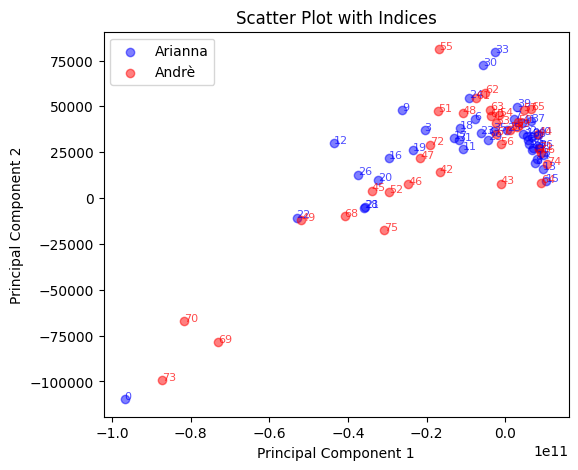

In [65]:
# PCA to reduce informations in 2 dimensions
pca = PCA(n_components=2)
X_train_aggregated = X_train.mean(axis=1)
print(X_train_aggregated.shape)
X_pca = pca.fit_transform(X_train_aggregated)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[y_train == 0][:, 0], X_pca[y_train == 0][:, 1], label='Arianna', color='blue', alpha=0.5)
plt.scatter(X_pca[y_train == 1][:, 0], X_pca[y_train == 1][:, 1], label='Andrè', color='red', alpha=0.5)

for i in range(len(X_pca)):
    if y_train[i] == 0:
        plt.text(X_pca[i, 0], X_pca[i, 1], str(i), fontsize=8, color='blue', alpha=0.7)
        
for i in range(len(X_pca)):
    if y_train[i] == 1:
        plt.text(X_pca[i, 0], X_pca[i, 1], str(i), fontsize=8, color='red', alpha=0.7)

plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot with Indices')
plt.show()

## Model training and Speaker recognition 

Recognizes who is speaking regardless of content.
Focus on the physical and behavioural properties of the voice.

In [74]:
# initialize and train the model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

n_samples, time_steps, n_features = X_train.shape
X_train_flattened = X_train.reshape(n_samples, time_steps * n_features)

model.fit(X_train_flattened, y_train)   # train the model, result: iperplane

threshold = 0.85

for i in range(1, 20): 
    path_test_audio = choose_test_audio(i)  # Select the test audio by index
    print(f"Testing audio: {path_test_audio}")
    
    # Extract MFCC embeddings and audio
    test_embedding, test_audio = extract_mfcc(path_test_audio)
    test_embedding_reshaped = test_embedding.reshape(1, -1)
    
    # Predict probabilities and confidence
    probabilities = model.predict_proba(test_embedding_reshaped)[0]
    prediction = np.argmax(probabilities)  # Speaker predicted
    confidence = probabilities[prediction]  # Confidence
    
    if prediction==0:
        predicted_speaker = 'Arianna'
    elif prediction==1:
        predicted_speaker = 'Andre'
    else:
        predicted_speaker = 'Others'

    # Print results
    print(f"Prediction: {predicted_speaker}, Confidence: {confidence:.2f}")
    
    if confidence < threshold:
        print("Others, below threshold\n")
    else:
        print(f"{predicted_speaker}, speaker recognized!\n")

    print('-----------------\n')

Testing audio: ./dataset/test/ others6.wav


Prediction: Others, Confidence: 1.00
Others, speaker recognized!

-----------------

Testing audio: ./dataset/test/andre-random.wav


Prediction: Andre, Confidence: 0.94
Andre, speaker recognized!

-----------------

Testing audio: ./dataset/test/arianna_pw1.wav


Prediction: Arianna, Confidence: 0.94
Arianna, speaker recognized!

-----------------

Testing audio: ./dataset/test/arianna_pw2.wav


Prediction: Arianna, Confidence: 0.91
Arianna, speaker recognized!

-----------------

Testing audio: ./dataset/test/arianna_random.wav


Prediction: Arianna, Confidence: 0.87
Arianna, speaker recognized!

-----------------

Testing audio: ./dataset/test/bird1.wav


Prediction: Others, Confidence: 0.94
Others, speaker recognized!

-----------------

Testing audio: ./dataset/test/bird2.wav


Prediction: Others, Confidence: 1.00
Others, speaker recognized!

-----------------

Testing audio: ./dataset/test/cat1.wav


Prediction: Others, Confidence: 0.99
Others, speaker recognized!

-----------------

Testing audio: ./dataset/test/cat2.wav


Prediction: Others, Confidence: 0.79
Others, below threshold

-----------------

Testing audio: ./dataset/test/dog1.wav


Prediction: Others, Confidence: 0.99
Others, speaker recognized!

-----------------

Testing audio: ./dataset/test/dog2.wav


Prediction: Others, Confidence: 1.00
Others, speaker recognized!

-----------------

Testing audio: ./dataset/test/dog3.wav


Prediction: Others, Confidence: 1.00
Others, speaker recognized!

-----------------

Testing audio: ./dataset/test/luca_random2.wav


Prediction: Andre, Confidence: 0.53
Others, below threshold

-----------------

Testing audio: ./dataset/test/others1.wav


Prediction: Others, Confidence: 0.92
Others, speaker recognized!

-----------------

Testing audio: ./dataset/test/others2.wav


Prediction: Others, Confidence: 1.00
Others, speaker recognized!

-----------------

Testing audio: ./dataset/test/others3.wav


Prediction: Others, Confidence: 1.00
Others, speaker recognized!

-----------------

Testing audio: ./dataset/test/others4.wav


Prediction: Others, Confidence: 1.00
Others, speaker recognized!

-----------------

Testing audio: ./dataset/test/others5.wav


Prediction: Others, Confidence: 1.00
Others, speaker recognized!

-----------------

Testing audio: ./dataset/test/pedro_falcon.wav


Prediction: Arianna, Confidence: 0.55
Others, below threshold

-----------------



## Password recognition

The system checks that the person is using their own password and not someone else's. The spoken password is transcribed into text and compared with the registered password of the identified user. To prevent transcription errors, the system also performs a direct audio verification, comparing the spoken sounds with the stored acoustic model of the password.

In [67]:
def recognize_password(path_test_audio, prediction):
    recognizer = sr.Recognizer()
    correct_password = 'Falcon' if prediction==0 else 'Tiger'

    with sr.AudioFile(path_test_audio) as source:
            test_audio = recognizer.record(source)

    try:
        # Use Google Web Speech API to trascript in text
        recognized_text = recognizer.recognize_google(test_audio)
        print(f"Recognized text: {recognized_text}")

        similarity = fuzz.ratio(recognized_text.lower(), correct_password.lower())

        # Confronta la parola riconosciuta con la password
        if similarity >= 80:
            print("Password recognized successfully!")
            print("Access allowed!")
        else:
            print("Password does not match...")
            print("Access denied.")
    
    except sr.UnknownValueError:
        print("Sorry, could not understand the audio.")
    except sr.RequestError as e:
        print(f"Error with the speech recognition service: {e}")

recognize_password(path_test_audio, prediction)

Recognized text: falcon
Password recognized successfully!
Access allowed!


Test toguether

In [ ]:
audios_folder = 
